<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/sslDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Supervised Learning with Projection Heads and Contrastive Learning
In this demo, I train a simple convolutional neural network on a very sparse
version of MNIST. 60,000 training examples, I only preserve 200 labels (meaning
we have 59,800 unlabled training examples, and 200 labled training examples).
In this notebook:

 - A simple supervised model is trained on only the 200 labels, resulting in a
 test set accuracy of 52.5%
 - A model is trained via self-supervised contrastive learning, yielding a test set accuracy of 59.7%
 - A model is trained via self-supervised contrastive learning, with a discarded projection head before refinement, yielding a test set accuracy of 63.6%

(results may be different due to stocasticity)

Given the incredible sparsity of the labled training set, I think 63.6% accuracy
is quite impressive, especially considering this is a proof of concept notebook
without significant hyperparameter refinement. This shows the power of self supervised learning using contrastive learning, and the importance of the projection head in that process.

If you like what you see, and want to work with me, visit https://danielwarfield.dev

# Table Of Contents

 - **Dataset Preperation:** Convert MNIST data into a very sparsely labled dataset
 - **Defining Model:** Create a simple convolutional netowrk with a fully connected projection head
 - **Training with Only Supervised Learning:** Establish baseline performance with only supervised learning
 - **Defining Augmentation:** Define the image augmentations necessary for self supervised learning
 - **Defining Contrastive Loss:** Define the loss function necessary for self supervised learning.
 - **Self Supervised Training:** Train the model to have general image understanding, without human defined lables, via self supervised learning with contrastive loss.
 - **Self Supervised Learning Training Progress:** A visual of the loss reduction compared to the learning rate scheduler, which is practically useful in understanding if SSL is actually doing anything productive
 - **Fine Tuning Self Supervised Model with Supervised Learning:** Training on the sparsely labled dataset, both with the original head from SSL, as well as new randomly initialized head
 - **Discussion:** A brief discussion


# Dataset Preperation
 - Setup PyTorch
 - Downloading the MNIST dataset
 - Remove labels from all but 200 training examples
 - Reformat the data into PyTorch tensors

In [1]:
"""
Downloading and rendering sample MNIST data
"""

#torch setup
import torch
import torchvision
import torchvision.datasets as datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#downloading mnist
mnist_trainset = datasets.MNIST(root='./data', train=True,
                                download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False,
                               download=True, transform=None)

#printing lengths
print('length of the training set: {}'.format(len(mnist_trainset)))
print('length of the test set: {}'.format(len(mnist_testset)))

#rendering a few examples
for i in range(3):
  print('the number {}:'.format(mnist_trainset[i][1]))
  mnist_trainset[i][0].show()

100%|██████████| 9912422/9912422 [00:00<00:00, 215649485.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89201541.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69067054.78it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21003890.59it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

length of the training set: 60000
length of the test set: 10000
the number 5:


the number 0:


the number 4:


In [12]:
"""
Creating un-labled data and transforming the data into more familiar types
"""

from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# ========== Data Extraction ==========
# unlabeling some data, and one hot encoding the labels which remain
# =====================================

partition_index = 200

def one_hot(y):
  #For converting a numpy array of 0-9 into a one hot encoding of vectors of length 10
  b = np.zeros((y.size, y.max() + 1))
  b[np.arange(y.size), y] = 1
  return b

print('processing labeld training x and y')
train_x = np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(partition_index))])
train_y = one_hot(np.asarray([np.asarray(mnist_trainset[i][1]) for i in tqdm(range(partition_index))]))

print('processing unlabled training data')
train_unlabled = np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(partition_index,len(mnist_trainset)))])

print('processing labeld test x and y')
test_x = np.asarray([np.asarray(mnist_testset[i][0]) for i in tqdm(range(len(mnist_testset)))])
test_y = one_hot(np.asarray([np.asarray(mnist_testset[i][1]) for i in tqdm(range(len(mnist_testset)))]))

# ========== Data Reformatting ==========
# adding a channel dimension and converting to pytorch
# =====================================

#adding a dimension to all X values to put them in the proper shape
#(batch size, channels, x, y)
print('reformatting shape...')
train_x = np.expand_dims(train_x, 1)
train_unlabled = np.expand_dims(train_unlabled, 1)
test_x = np.expand_dims(test_x, 1)

#converting data to pytorch type
torch_train_x = torch.tensor(train_x.astype(np.float32), requires_grad=True).to(device)
torch_train_y = torch.tensor(train_y).to(device)
torch_test_x = torch.tensor(test_x.astype(np.float32), requires_grad=True).to(device)
torch_test_y = torch.tensor(test_y).to(device)
torch_train_unlabled = torch.tensor(train_unlabled.astype(np.float32), requires_grad=True).to(device)

print('done')

processing labeld training x and y


100%|██████████| 200/200 [00:00<00:00, 13853.33it/s]


processing unlabled training data


100%|██████████| 59800/59800 [00:04<00:00, 12532.35it/s]


processing labeld test x and y


100%|██████████| 10000/10000 [00:00<00:00, 42868.00it/s]


reformatting shape...
done


# Defining Model
The model is a very simple, low parameter convolutional model. There is a
convolutional backbone with max pooling, and a fully connected head. The "head"
is what is refered to as the "projection head" in the original blog post, and
is re-initialized later in one of the examples.

In [40]:
"""
Using PyTorch to create a modified, smaller version of AlexNet
"""
import torch.nn.functional as F
import torch.nn as nn

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        return x


class Head(nn.Module):
    def __init__(self, n_class=10):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, n_class)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,1)


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = Backbone()
        self.head = Head()

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model_baseline = Model()
print(model_baseline(torch_train_x[:1]).shape)
model_baseline

torch.Size([1, 10])


Model(
  (backbone): Backbone(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=10, bias=True)
  )
)

# Training with Only Supervised Learning
attempting to train a model using only supervised learning with the 200 labled
training samples. Naturally, performance is very poor as a result of a lack of
sufficient data.

100%|██████████| 20000/20000 [14:13<00:00, 23.45it/s]


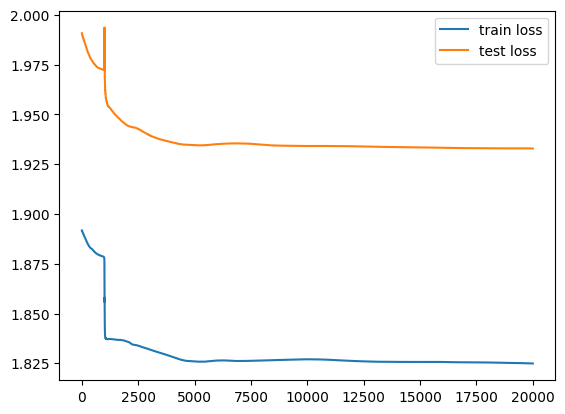

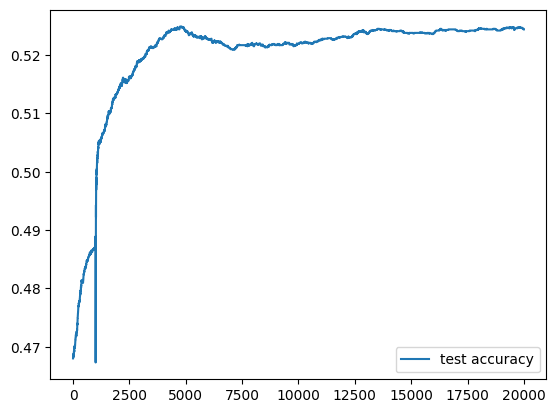

max accuracy: 0.5249


In [42]:
"""
Training model using only supervised learning, and rendering the results
"""

def supervised_train(model):

    #defining key hyperparamaters explicitly (instead of hyperparamater search)
    batch_size = 64
    lr = 0.001
    momentum = 0.9
    num_epochs = 20000

    #defining a stocastic gradient descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #defining loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    train_hist = []
    test_hist = []
    test_accuracy = []

    for epoch in tqdm(range(num_epochs)):

        #iterating over all batches
        for i in range(int(len(train_x)/batch_size)-1):

            #Put the model in training mode, so that things like dropout work
            model.train(True)

            # Zero gradients
            optimizer.zero_grad()

            #extracting X and y values from the batch
            X = torch_train_x[i*batch_size: (i+1)*batch_size]
            y = torch_train_y[i*batch_size: (i+1)*batch_size]

            # Make predictions for this batch
            y_pred = model(X)

            #compute gradients
            loss_fn(model(X), y).backward()

            # Adjust learning weights
            optimizer.step()

        with torch.no_grad():

            #Disable things like dropout
            model.train(False)

            #calculating epoch training and test loss
            train_loss = loss_fn(model(torch_train_x), torch_train_y).cpu().numpy()
            y_pred_test = model(torch_test_x)
            test_loss = loss_fn(y_pred_test, torch_test_y).cpu().numpy()

            train_hist.append(train_loss)
            test_hist.append(test_loss)

            #computing test accuracy
            matches = np.equal(np.argmax(y_pred_test.cpu().numpy(), axis=1), np.argmax(torch_test_y.cpu().numpy(), axis=1))
            test_accuracy.append(matches.sum()/len(matches))

    import matplotlib.pyplot as plt
    plt.plot(train_hist, label = 'train loss')
    plt.plot(test_hist, label = 'test loss')
    plt.legend()
    plt.show()
    plt.plot(test_accuracy, label = 'test accuracy')
    plt.legend()
    plt.show()

    maxacc = max(test_accuracy)
    print('max accuracy: {}'.format(maxacc))

    return maxacc

supervised_maxacc = supervised_train(model_baseline)


# Defining Augmentation
Augmentations are a crucial part of contrastive self supervision. This function takes a tensor and produces augmentations which morph the images of numbers such they are signifficantly changed, but still recognizable as the original number.

A reference I used:
https://theaisummer.com/simclr/


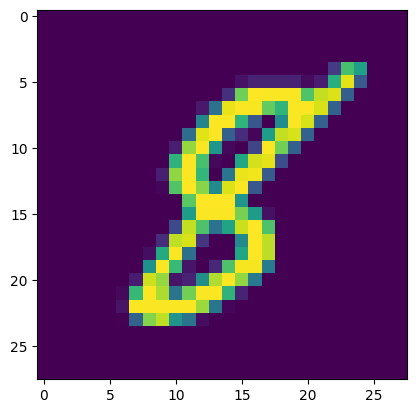

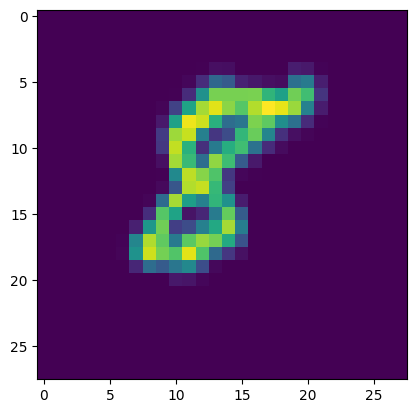

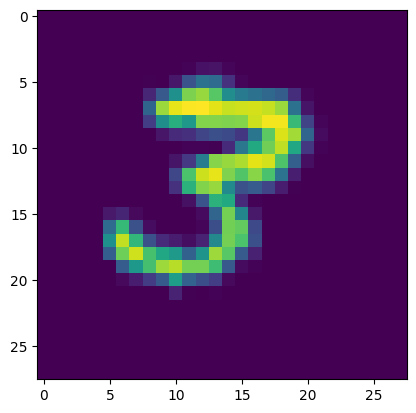

In [31]:
import torch
import torchvision.transforms as T

class Augment:
   """
   A stochastic data augmentation module
   Transforms any given data example randomly
   resulting in two correlated views of the same example,
   denoted x ̃i and x ̃j, which we consider as a positive pair.
   """

   def __init__(self):

       blur = T.GaussianBlur((3, 3), (0.1, 2.0))

       self.train_transform = torch.nn.Sequential(
           T.RandomAffine(degrees = (-50,50), translate = (0.1,0.1), scale=(0.5,1.5), shear=0.2),
           T.RandomPerspective(0.4,0.5),
           T.RandomPerspective(0.2,0.5),
           T.RandomPerspective(0.2,0.5),
           T.RandomApply([blur], p=0.25),
           T.RandomApply([blur], p=0.25)
       )

   def __call__(self, x):
       return self.train_transform(x), self.train_transform(x)

a = Augment()

i = 2
plt.imshow(torch_train_unlabled.cpu().detach().numpy()[i,0])
plt.show()

aug = a(torch_train_unlabled[0:100])

plt.imshow(aug[0].cpu().detach().numpy()[i,0])
plt.show()
plt.imshow(aug[0].cpu().detach().numpy()[i+1,0])
plt.show()

# Defining Contrastive Loss
Contrastiv loss is the loss function which defines how the model should seperate different examples. In essence, Contrastive loss punishes when similar examples are far apart, and when differnt examples are close together.

<iframe src="https://giphy.com/embed/8SZhj0qY3XlHcr1150" width="432" height="480" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/simclr-8SZhj0qY3XlHcr1150">A Visual Demonstration of Contrastive Loss</a></p>

A reference I used:
https://theaisummer.com/simclr/

In [3]:
class ContrastiveLoss(nn.Module):
   """
   Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
   """
   def __init__(self, batch_size, temperature=0.5):
       """
       Defining certain constants used between calculations. The mask is important
       in understanding which are positive and negative examples. For more
       information see https://theaisummer.com/simclr/
       """
       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)

   def calc_similarity_batch(self, a, b):
       """
       Defines the cosin similarity between one example, and all other examples.
       For more information see https://theaisummer.com/simclr/
       """
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       """
       The actual loss function, where proj_1 and proj_2 are embeddings from the
       projection head. This function calculates the cosin similarity between
       all vectors, and rewards closeness between examples which come from the
       same example, and farness for examples which do not. For more information
       see https://theaisummer.com/simclr/
       """
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

NameError: ignored

In [33]:
"""
testing the loss function on fake data, to see if it works effectively
"""
loss = ContrastiveLoss(torch_train_x.shape[0]).forward
fake_proj_0, fake_proj_1 = a(torch_train_x)
fake_proj_0 = fake_proj_0[:,0,:,0]
fake_proj_1 = fake_proj_1[:,0,:,0]
loss(fake_proj_0, fake_proj_1)

tensor(6.1486, device='cuda:0', grad_fn=<DivBackward0>)

# Self Supervised Training

Pairing augmentations, and the contrastive loss function, to train a model to be able to distinguish between similar and different images of charecters. This model will then serve as an initialization for further model fine tuning via supervised learning.


**Useful References:**

General: https://theaisummer.com/simclr/

PyTorch Schedulers: https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#eec7

In [34]:
from torch.optim.lr_scheduler import ExponentialLR

model = Model()
model.train()

batch_size = 512
epoch_size = round(torch_train_unlabled.shape[0]/batch_size)-1
num_epochs = 100
patience = 5
cutoff_ratio = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_examples = train_unlabled.shape[0]
lossfn = ContrastiveLoss(batch_size).forward
augmentfn = Augment() #augment function

loss_hist = []
improvement_hist = []
schedule_hist = []

scheduler = ExponentialLR(optimizer,
                          gamma = 0.95)

patience_count=0
avg_loss = 1e10
for i in range(num_epochs):

    print('epoch {}/{}'.format(i,num_epochs))

    total_loss = 0
    loss_change = 0

    for j in tqdm(range(epoch_size)):

        #getting random batch
        X = torch_train_unlabled[j*batch_size: (j+1)*batch_size]

        #creating pairs of augmented batches
        X_aug_i, X_aug_j = augmentfn(X)

        #ensuring gradients are zero
        optimizer.zero_grad()

        #passing through the model
        z_i = model(X_aug_i)
        z_j = model(X_aug_j)

        #calculating loss on the model embeddings, and computing gradients
        loss = lossfn(z_i, z_j)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        #checking to see if backpropegation resulted in a reduction of the loss function
        if True:
            #passing through the model, now that parameters have been updated
            z_i = model(X_aug_i)
            z_j = model(X_aug_j)

            #calculating new loss value
            new_loss = lossfn(z_i, z_j)

            loss_change += new_loss.cpu().detach().numpy() - loss.cpu().detach().numpy()

        total_loss += loss.cpu().detach().numpy()

        #step learning rate scheduler
        schedule_hist.append(scheduler.get_last_lr())

    scheduler.step()

    #calculating percentage loss reduction
    new_avg_loss = total_loss/epoch_size
    per_loss_reduction = (avg_loss-new_avg_loss)/avg_loss
    print('Percentage Loss Reduction: {}'.format(per_loss_reduction))

    #deciding to stop if loss is not decreasing fast enough
    if per_loss_reduction < cutoff_ratio:
        patience_count+=1
        print('patience counter: {}'.format(patience_count))
        if patience_count > patience:
            break
    else:
        patience_count = 0

    #setting new loss as previous loss
    avg_loss = new_avg_loss

    #book keeping
    avg_improvement = loss_change/epoch_size
    loss_hist.append(avg_loss)
    improvement_hist.append(avg_improvement)
    print('Average Loss: {}'.format(avg_loss))
    print('Average Loss change (if calculated): {}'.format(avg_improvement))


epoch 0/100


100%|██████████| 116/116 [00:27<00:00,  4.27it/s]


Percentage Loss Reduction: 0.9999999993151959
Average Loss: 6.848041291894583
Average Loss change (if calculated): -0.01992147133268159
epoch 1/100


100%|██████████| 116/116 [00:25<00:00,  4.54it/s]


Percentage Loss Reduction: 0.02761450766361156
Average Loss: 6.658936003158832
Average Loss change (if calculated): -0.025475666440766435
epoch 2/100


100%|██████████| 116/116 [00:25<00:00,  4.54it/s]


Percentage Loss Reduction: 0.02182705715330352
Average Loss: 6.513591026437694
Average Loss change (if calculated): -0.020024377724220013
epoch 3/100


100%|██████████| 116/116 [00:26<00:00,  4.38it/s]


Percentage Loss Reduction: 0.00788365712569554
Average Loss: 6.462240108128252
Average Loss change (if calculated): -0.019849218171218347
epoch 4/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: 0.008046210388291142
Average Loss: 6.4102435646385985
Average Loss change (if calculated): -0.01674765965034222
epoch 5/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: 0.0037767664200002295
Average Loss: 6.386033571999649
Average Loss change (if calculated): -0.015815582768670445
epoch 6/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.0005590571778010578
patience counter: 1
Average Loss: 6.382463414093544
Average Loss change (if calculated): -0.016948510860574657
epoch 7/100


100%|██████████| 116/116 [00:26<00:00,  4.41it/s]


Percentage Loss Reduction: 0.006255775227826797
Average Loss: 6.342536157575147
Average Loss change (if calculated): -0.012253827062146417
epoch 8/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: 0.0036662154073206325
Average Loss: 6.3192830537927565
Average Loss change (if calculated): -0.011606475402568948
epoch 9/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.0037872264024975274
Average Loss: 6.295350498166577
Average Loss change (if calculated): -0.011138093882593614
epoch 10/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -0.0023387918897786767
patience counter: 1
Average Loss: 6.3100740128550035
Average Loss change (if calculated): -0.012399833777855182
epoch 11/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: 0.005331512517209969
Average Loss: 6.276431774270946
Average Loss change (if calculated): -0.010326529371327367
epoch 12/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: -0.002182862570463071
patience counter: 1
Average Loss: 6.290132362267067
Average Loss change (if calculated): -0.01054087178460483
epoch 13/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.0025214766543459302
Average Loss: 6.274271940362865
Average Loss change (if calculated): -0.01020263803416285
epoch 14/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.001710597440703886
Average Loss: 6.2635391868394
Average Loss change (if calculated): -0.010184752530065077
epoch 15/100


100%|██████████| 116/116 [00:26<00:00,  4.46it/s]


Percentage Loss Reduction: 0.004075421231451637
Average Loss: 6.238012626253325
Average Loss change (if calculated): -0.008724278417126885
epoch 16/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: -0.002272293077185555
patience counter: 1
Average Loss: 6.252187219159357
Average Loss change (if calculated): -0.008212295071832064
epoch 17/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: 0.0013656145150851547
Average Loss: 6.243649141541843
Average Loss change (if calculated): -0.008183462866421404
epoch 18/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.004252847162136745
Average Loss: 6.217095856008859
Average Loss change (if calculated): -0.007589093570051522
epoch 19/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]


Percentage Loss Reduction: 0.001597395587245353
Average Loss: 6.207164694522989
Average Loss change (if calculated): -0.0067755682715054215
epoch 20/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: -3.326060399582363e-05
patience counter: 1
Average Loss: 6.20737114856983
Average Loss change (if calculated): -0.005731401772334658
epoch 21/100


100%|██████████| 116/116 [00:25<00:00,  4.52it/s]


Percentage Loss Reduction: 0.0024564460853848807
Average Loss: 6.192123076011395
Average Loss change (if calculated): -0.005882633143457873
epoch 22/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: -0.002820739190953576
patience counter: 1
Average Loss: 6.209589440247108
Average Loss change (if calculated): -0.006083077397839776
epoch 23/100


100%|██████████| 116/116 [00:26<00:00,  4.45it/s]


Percentage Loss Reduction: 0.0037994676009638338
Average Loss: 6.185996306353602
Average Loss change (if calculated): -0.006368147915807264
epoch 24/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -0.00138558803457343
patience counter: 1
Average Loss: 6.194567548817601
Average Loss change (if calculated): -0.0050496561773892105
epoch 25/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: 0.001739002427318402
Average Loss: 6.18379518081402
Average Loss change (if calculated): -0.0050808479045999465
epoch 26/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]


Percentage Loss Reduction: -0.0008140722737288555
patience counter: 1
Average Loss: 6.1888292370171385
Average Loss change (if calculated): -0.005540888884971882
epoch 27/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -0.0012436642841019805
patience counter: 2
Average Loss: 6.196526062899623
Average Loss change (if calculated): -0.0050919549218539535
epoch 28/100


100%|██████████| 116/116 [00:25<00:00,  4.52it/s]


Percentage Loss Reduction: 0.002822281998782418
Average Loss: 6.179037718937315
Average Loss change (if calculated): -0.003972867439533102
epoch 29/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: -0.001992552773553289
patience counter: 1
Average Loss: 6.191349777682074
Average Loss change (if calculated): -0.005119693690332873
epoch 30/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: 0.0022358185685367408
Average Loss: 6.177507042884827
Average Loss change (if calculated): -0.004085248914258233
epoch 31/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: -0.0006532939101641356
patience counter: 1
Average Loss: 6.181542770615939
Average Loss change (if calculated): -0.004740028545774263
epoch 32/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -0.000784128474876562
patience counter: 2
Average Loss: 6.186389894321047
Average Loss change (if calculated): -0.003937930896364409
epoch 33/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: 0.003949966024131481
Average Loss: 6.161953864426448
Average Loss change (if calculated): -0.003628406031378384
epoch 34/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: -0.0016945526785947618
patience counter: 1
Average Loss: 6.172395619852789
Average Loss change (if calculated): -0.003912605088332604
epoch 35/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: -0.0004375533247947622
patience counter: 2
Average Loss: 6.175096372078205
Average Loss change (if calculated): -0.003349102776626061
epoch 36/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: 0.0012742610150902104
Average Loss: 6.16722768750684
Average Loss change (if calculated): -0.002994746997438628
epoch 37/100


100%|██████████| 116/116 [00:25<00:00,  4.52it/s]


Percentage Loss Reduction: 0.0019300190126741103
Average Loss: 6.155324820814462
Average Loss change (if calculated): -0.0032668442561708646
epoch 38/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]


Percentage Loss Reduction: -4.092951281547135e-05
patience counter: 1
Average Loss: 6.155576755260599
Average Loss change (if calculated): -0.0025728529897229425
epoch 39/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: 6.54566264114429e-05
patience counter: 2
Average Loss: 6.155173831972583
Average Loss change (if calculated): -0.0026212560719457165
epoch 40/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: 0.000517431642151756
patience counter: 3
Average Loss: 6.151988950268976
Average Loss change (if calculated): -0.0026378138311978043
epoch 41/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: -0.0026367418561416066
patience counter: 4
Average Loss: 6.168210157032671
Average Loss change (if calculated): -0.0034151159483810953
epoch 42/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: 0.0006359691412457083
patience counter: 5
Average Loss: 6.1642873657160795
Average Loss change (if calculated): -0.0024158050274026804
epoch 43/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: 0.0031194906405234515
Average Loss: 6.145057928973231
Average Loss change (if calculated): -0.002062086401314571
epoch 44/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]


Percentage Loss Reduction: -0.00104348903531477
patience counter: 1
Average Loss: 6.151470229543489
Average Loss change (if calculated): -0.002304512878944134
epoch 45/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: 0.0017705101076947178
Average Loss: 6.140578989324899
Average Loss change (if calculated): -0.0016805879000959725
epoch 46/100


100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Percentage Loss Reduction: -0.0015475938100078697
patience counter: 1
Average Loss: 6.150082111358643
Average Loss change (if calculated): -0.002191847768323175
epoch 47/100


100%|██████████| 116/116 [00:26<00:00,  4.43it/s]


Percentage Loss Reduction: 0.002687220899755318
Average Loss: 6.133555482173788
Average Loss change (if calculated): -0.0015508388650828395
epoch 48/100


100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Percentage Loss Reduction: -0.0010425788375602624
patience counter: 1
Average Loss: 6.139950197318504
Average Loss change (if calculated): -0.001782322752064672
epoch 49/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -0.0005400828503249148
patience counter: 2
Average Loss: 6.143266279121925
Average Loss change (if calculated): -0.0015961342844469793
epoch 50/100


100%|██████████| 116/116 [00:25<00:00,  4.50it/s]


Percentage Loss Reduction: -7.155445804375024e-05
patience counter: 3
Average Loss: 6.143705857211146
Average Loss change (if calculated): -0.0015071753797859981
epoch 51/100


100%|██████████| 116/116 [00:25<00:00,  4.51it/s]


Percentage Loss Reduction: -0.0011742967582260447
patience counter: 4
Average Loss: 6.150920391082764
Average Loss change (if calculated): -0.0015028591813712284
epoch 52/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]


Percentage Loss Reduction: 0.0008801267878934605
patience counter: 5
Average Loss: 6.145506801276372
Average Loss change (if calculated): -0.0014941610138991784
epoch 53/100


100%|██████████| 116/116 [00:25<00:00,  4.49it/s]

Percentage Loss Reduction: -0.0012384643495572142
patience counter: 6


# Self Supervised Learning Training Progress
prints a graph of the learning rate and loss results from self supervised learning

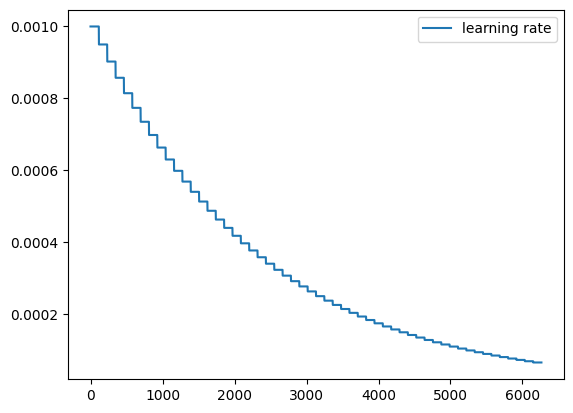

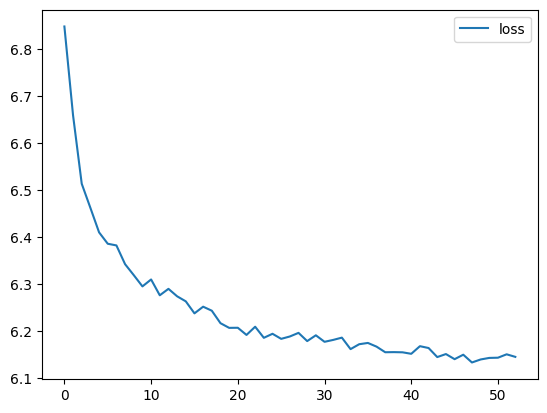

In [35]:
plt.plot(schedule_hist, label='learning rate')
plt.legend()
plt.show()
plt.plot(loss_hist, label = 'loss')
plt.legend()
plt.show()

# Fine Tuning Self Supervised Model with Supervised Learning
in this example, fine tune the model, both with the original projection head as well as with a new projection head, and display the results of each.

100%|██████████| 20000/20000 [14:13<00:00, 23.44it/s]


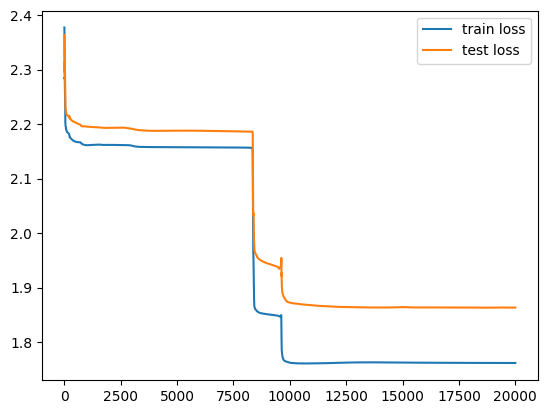

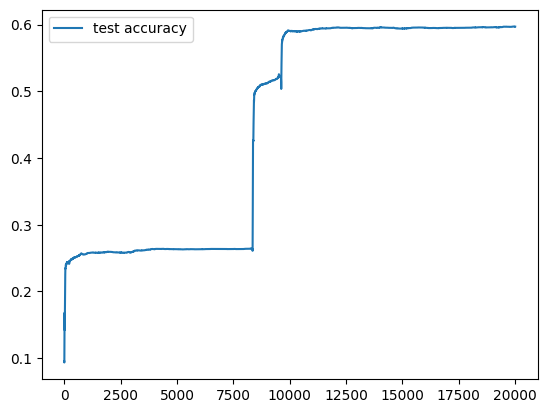

max accuracy: 0.5972


100%|██████████| 20000/20000 [14:22<00:00, 23.18it/s]


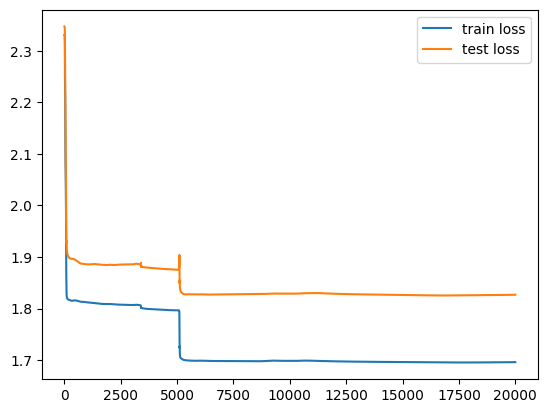

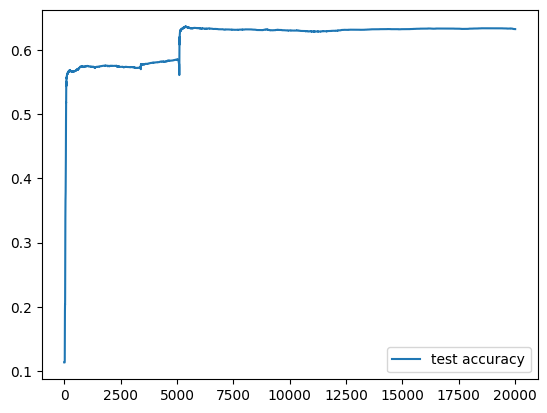

max accuracy: 0.6363


In [43]:
import copy

#creating duplicate models for finetuning
model_same_head = copy.deepcopy(model)
model_new_head = copy.deepcopy(model)

#replacing the projection head with a randomly initialized head
#for one of the models
model_new_head.head = Head()

#training models
same_head_maxacc = supervised_train(model_same_head)
new_head_maxacc = supervised_train(model_new_head)

# Discussion
As can be seen, pure supevised learning perfomed the worst, self supervised learning with supervised learning performed second best, and self supervised learning with supervised learning on a new head performed best.

These results are purely demonstrative; there was no significant hyperparameter optimization which would be necessary in production machine learning tasks. However, this notebook does proove the theoretical utility of self supervision, and the importance of careful refinement of the projection head.

**Results**

 - Only supervised learning: 52.5% accuracy
 - SSL and supervised: 59.7% accuracy
 - SSL and supervised on a new head: 63.6%
